<h1>
  <center>
    Differential evolution with
  </center>
  <center>
    adaptive mutation and crossover strategies
  </center>
</h1>

In [22]:
# Import NIST models
import sys
sys.path.append("../")
from nist_models.nist_models import NISTModel

# Import other useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## What is differential evolution (DE)?
Differential evolution 

## Improving differential evolution – DEAMC algorithm

In [43]:
# Helper functions for the DEAMC algorithm applied to the NIST problem

def residual_sum_squares(params, x_data, y_data, model_func):
  """
    Compute the Residual Sum of Squares (RSS) for a nonlinear regression model
    Input:
      - params: array-like (model parameters to evaluate, e.g. [b1, b2, ..., bD])
      - x_data: array-like (input of observations)
      - y_data: array-like (output of observations)
      - model_func: callable (function that computes the model predictions)
    Output:
      - float: RSS = sum((y_data - model_prediction)^2)
  """
  # Compute model predictions for given parameters
  y_pred = model_func(x_data, *params)
  
  # Calculate residuals (difference between observed and predicted)
  residuals = y_data - y_pred
  
  # Return sum of squared residuals
  return np.sum(residuals ** 2)

def get_nist_bounds(certified_values, k=10, default_low=0, default_high=100):
  """
    Generate possible bounds for NIST problems based on certified values.
    Input:
      - certified: np.array (certified parameter values)
      - k: float (multiplier for bounds)
      - default_low: float (default lower bound if certified value is zero)
      - default_high: float (default upper bound if certified value is zero)
    Output:
    - 
  """
  bounds = []
  for val in certified_values:
    if val == 0:
      bounds.append((default_low, default_high))
    else:
      L = val / k
      U = val * k
      bounds.append((min(L, U), max(L, U)))  # Handle negative values
  return bounds

def initialize_population(NP, D, bounds):
  """
    Initialize a list of NP vectors (dimension D) with random values from the interval described by bounds
    Input:
      - NP: int (population size)
      - D: int (problem dimension)
      - bounds: list[tuple(float, float)] (lower and upper bounds for each parameter)
    Output:
      - population: np.ndarray (population matrix of shape (NP, D).
  """
  population = np.zeros((NP, D))

  # Uniform random initialization within bounds
  for j in range(D):
    L_j, U_j = bounds[j]
    population[:, j] = np.random.uniform(L_j, U_j, size=NP)
  
  return population

def mutation_operation(f, target_idx, population, pm1):
  """
   Perform mutation on a target vector using either Classic Mutation (CM) or Sorting Mutation (SM).
    Input:
      - f: lambda function (objective function to be minimized)
      - target_idx:  int (index of the target vector in the population)
      - population: np.ndarray (current population (shape: [NP, D]))
      - pm1: float (probability of using Classic Mutation (CM))
    Output:
      - xm: np.ndarray (mutant vector)
      - mutation_type: string ("CM" or "SM")
  """
  NP, D = population.shape
  target = population[target_idx]
  
  # Select three distinct random indices != target_idx
  candidates = [i for i in range(NP) if i != target_idx]
  r1, r2, r3 = np.random.choice(candidates, 3, replace=False)

  # Select F (random scaling factor in the range [0.5, 0.7])
  F = np.random.uniform(0.5, 0.7)
  
  if np.random.rand() < pm1:
    # Classic Mutation (CM)
    mutation_type = "CM"
    xm = population[r1] + F * (population[r2] - population[r3])
  else:
    # Sorting Mutation (SM)
    mutation_type = "SM"
    # Sort r1, r2, r3 by their fitness (ascending: best to worst)
    indices = [r1, r2, r3]
    fitness = [f(population[i]) for i in indices]
    sorted_indices = [x for _, x in sorted(zip(fitness, indices))]
    
    x_r1, x_r2, x_r3 = population[sorted_indices]
    xm = x_r1 + F * (x_r2 - x_r3)
  
  return xm, mutation_type

def crossover_operation(target, mutant, CR):
  """
    Perform crossover between target and mutant vectors with adaptive CR ranges.
    Input:
      - target: np.array (target vector (shape: [D]))
      - mutant: np.array (mutant vector (shape: [D]))
      - CR: float (crossover rate (dynamically selected from [0,0.1] or [0.9,1]))
    Output:
      - trial: np.array (trial vector (shape: [D]))
  """
  D = len(target)
  trial = np.zeros(D)
  
  # Randomly select a fixed index to ensure at least one parameter changes
  IC = np.random.randint(0, D)
  
  for j in range(D):
    if (np.random.rand() < CR) or (j == IC):
      trial[j] = mutant[j]  # Take from mutant
    else:
      trial[j] = target[j]  # Take from target
  
  return trial

def adaptive_crossover(target, mutant, pc1):
  """
    Adaptive crossover wrapper that selects CR range based on success probability (pc1).
    Input:
      - target: np.ndarray (target vector)
      - mutant: np.ndarray (mutant vector)
      - pc1: float (probability of using low CR range [0,0.1])
    Output:
      - trial: np.ndarray (trial vector (shape: [D]))
      - crossover_range: string("low", "high")
  """
  # Determine CR range based on pc1
  if np.random.rand() < pc1:
    CR = np.random.uniform(0, 0.1)
    crossover_range = "low"
  else:
    CR = np.random.uniform(0.9, 1)
    crossover_range = "high"
  
  # Perform crossover
  trial = crossover_operation(target, mutant, CR)
  
  return trial, crossover_range

In [44]:
# DEAMC algorithm for the NIST problem

def differential_evolution_adaptive_mutation_crossover(f, D, bounds, eps = 1e-10):
  """
    Implements the differential evolution with adaptive mutation and crossover strategy algorithm
    Input:
      - f: lambda function (objective function to be minimized)
      - D: int (problem dimension)
      - bounds: list[tuple(float, float)] (lower and upper bounds for each parameter)
    Output:
      - xb: np.array (best configuration)
      - fb: float (best fitness value)
  """
  # Initialize control parameters
  NP = 10 * D # Population size
  nf = 0 # Number of function evaluations
  maxnf = 40000 * D # Maximum number of function evaluations

  pm1 = pm2 = 0.5 # The initial probabilities for using CM and SM
  pc1 = pc2 = 0.5 # The initial probabilities for using low and high crossover rates

  nm1 = nm2 = 0 # The initial counters corresponding to pm1 and pm2
  nc1 = nc2 = 0 # The initial counters corresponding to pc1 and pc2

  # Initialize list of population vectors
  population = initialize_population(NP, D, bounds)

  # Find initial best and worst
  fb = float('inf')
  fw = -float('inf')
  for i, x in enumerate(population):
    fx = f(x)
    nf += 1
    if fx < fb:
      xb, fb = x.copy(), fx
    if fx > fw:
      xw, fw = x.copy(), fx
  
  # Stopping condition
  while not np.log((fw + 1e-300)/(fb + 1e-300)) < eps and nf < maxnf:
    # Generate new population
    for i in range(NP):
      # Select target vector
      x = population[i]
      fx = f(x)
      
      # Mutate vector
      xm, mutation_type = mutation_operation(f, i, population, pm1)
      xm = np.clip(xm, [b[0] for b in bounds], [b[1] for b in bounds])

      # Crossover vector
      xc, crossover_range = adaptive_crossover(x, xm, pc1)

      # Selection
      fc = f(xc)
      nf += 1
      if fc < fx:
        # Replace target with trial
        population[i] = xc

        # Update success counters
        if mutation_type == "CM":
          nm1 += 1
        else:
          nm2 += 1

        if crossover_range == 'low':
          nc1 += 1
        else:
          nc2 += 1
      
        # Update global best solution
        if fc < fb:
          xb, fb = xc.copy(), fc

    # Update worst value
    fw = max(f(x) for x in population)

    # Adapt probabilities every 100 evaluations
    if (nm1 + nm2) >= 100:
      # Update mutation probabilities
      pm1 = 0.9*pm1 + 0.1*(nm1/(nm1 + nm2))
      pm2 = 1 - pm1
      nm1 = nm2 = 0
        
    if (nc1 + nc2) >= 100:
      # Update crossover probabilities
      pc1 = 0.9*pc1 + 0.1*(nc1/(nc1 + nc2))
      pc2 = 1 - pc1
      nc1 = nc2 = 0
    
    # Early stopping if converged
    if np.log(fw/fb) < eps:
      break

  return xb, fb
    
def deamc_nist_model(model_name: str):
  """
    Applies the differential evolution with adaptive mutation and crossover strategy algorithm
    for a certain NIST nonlinear least squares regression model based on its name
    Input:
      - model_name: str (name of NIST model for nonlinear regression)
  """
  model = NISTModel(model_name)
  model_func = model.model()
  data = model.data()
  rss = lambda x: residual_sum_squares(x, np.array(data['x']), np.array(data['y']), model_func)
  D = model.get_parameters_count()
  bounds = get_nist_bounds(model.get_certified_values())

  return differential_evolution_adaptive_mutation_crossover(rss, D, bounds)

In [50]:
xb, fb = deamc_nist_model("Gauss1")

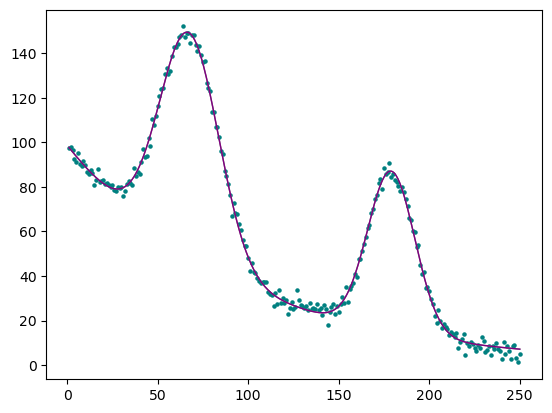

In [46]:
model = NISTModel("Gauss1")
model_df = model.data()
# Plot model function with certified parameters
x = np.linspace(min(model_df['x']), max(model_df['x']), 500)
f = np.zeros(500)
f_estimated = np.zeros(500)
for i in range(500):
  f[i] = model.evaluate(x[i], model.get_certified_values())
  f_estimated[i] = model.evaluate(x[i], xb)
plt.plot(x, f, linewidth=1, color='grey')
plt.plot(x, f, linewidth=1, color='purple')
# Plot observations
plt.scatter(model_df['x'], model_df['y'], s=5, color='teal')
plt.show()

## References
- Wongsa, Watchara & Puphasuk, Pikul & Wetweerapong, Jeerayut. (2024). *Differential evolution with adaptive mutation and crossover strategies for nonlinear regression problems*. Bulletin of Electrical Engineering and Informatics. 13. 3503-3514. 10.11591/eei.v13i5.6417. 